# 05 Quantile forecasting using Gradient Boosted Trees

In [1]:
import sys
sys.executable

'/usr/local/bin/python'

## Imports

In [2]:
import re

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import stock_utils.constants as cnst
import stock_utils.data as sd

pd.set_option('display.max_columns', None)

NSE_DATA_DIR = PosixPath('../data/NSE') | Valid: True
SCREENER_EPS_DATA_DIR = PosixPath('../data/Screener.in/EPS') | Valid: True
PROCESSED_DATA_DIR = PosixPath('../data/processed') | Valid: True


## Constants

In [3]:
QUANTILE_LB, QUANTILE_UB = 0.1, 0.9

stock_symbols = sd.get_all_stock_symbols(
    cnst.NSE_DATA_DIR
)

stock_symbols

['DEEPAKFERT', 'HDFCBANK', 'INDIGOPNTS', 'ITBEES', 'JUBLFOOD', 'NH']

In [4]:
STOCK_SYMBOL = stock_symbols[5]
STOCK_SYMBOL

'NH'

## Loading stock data

In [5]:
stock_data = sd.StockData(STOCK_SYMBOL)
stock_data

Symbol: NH
Total records: 1087
First record: 2020-01-01
Last record: 2024-04-26

## Modelling

### Target columns

In [6]:
target_cols = stock_data.standardized.filter(regex = "Target.*").columns.to_list()
target_cols

['Target 3D', 'Target 7D', 'Target 15D', 'Target 30D']

In [7]:
pred_input_df = stock_data.standardized.drop(columns = target_cols)
pred_input_df.shape

(1087, 42)

In [8]:
stock_data.standardized[target_cols].describe()

,Target 3D,Target 7D,Target 15D,Target 30D
count,1084.000000,1080.000000,1072.000000,1057.000000
mean,1.004396,1.009989,1.021326,1.041851
std,0.036063,0.052965,0.074810,0.100385
min,0.788000,0.726000,0.705000,0.644000
25%,0.983750,0.980000,0.974000,0.980000
50%,1.002000,1.004000,1.015000,1.040000
75%,1.021000,1.038250,1.065000,1.102000
max,1.173000,1.285000,1.265000,1.393000


### Data processing

In [9]:
def get_training_data(target_col: str):
    print(f"Target: {target_col}")
    X_df = stock_data.standardized[
        stock_data.standardized[target_col].notnull()
    ].drop(columns = target_cols).copy()
    y = stock_data.standardized[
        stock_data.standardized[target_col].notnull()
    ][target_col].copy()
    print(f"X.shape: {X_df.shape}")
    print(f"y.shape: {y.shape}")

    return X_df, y

### Grid search parameters

In [10]:
param_dict = {
    "n_estimators": [100, 125, 150],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4],
    "max_features": ["log2", "sqrt", 0.25],
    "subsample": [0.75, 1.0]
}

feature_importances = pd.DataFrame(
    index = stock_data.standardized.drop(columns = target_cols).columns.to_list()
)

### Model building

In [11]:
def get_model():
    gb_model = GradientBoostingRegressor(
        loss = "squared_error",
        random_state = cnst.RANDOM_STATE
    )

    grid_cv = RandomizedSearchCV(
        gb_model,
        param_dict,
        n_iter = 12,
        cv = 5,
        n_jobs = -1,
        random_state = cnst.RANDOM_STATE
    )

    return grid_cv

def get_quantile_model(quantile: float):
    gb_model = GradientBoostingRegressor(
        loss = "quantile",
        alpha = quantile,
        random_state = cnst.RANDOM_STATE
    )

    grid_cv = RandomizedSearchCV(
        gb_model,
        param_dict,
        n_iter = 12,
        cv = 5,
        n_jobs = -1,
        random_state = cnst.RANDOM_STATE
    )

    return grid_cv

def print_results(y, preds):
    print(f"Target std: {y.std():.3f}")
    print(f"R2: {r2_score(y, preds):.3f}")
    print(f"MSE: {mean_squared_error(y, preds, squared = False):.3f}")
    print(f"MAE: {mean_absolute_error(y, preds):.3f}")

## Training

### `Target 3D`

#### Forecasting model

In [12]:
target_col = target_cols[0]
X, y = get_training_data(target_col)

Target: Target 3D
X.shape: (1084, 42)
y.shape: (1084,)


In [13]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 0.75,
 'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 3,
 'learning_rate': 0.05}

In [14]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.303193,0.033975,0.004795,0.001535,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.169996,-0.014685,-0.031932,-0.174406,-0.062006,-0.090605,0.068337,1
2,0.382223,0.053595,0.006046,0.001298,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.221253,-0.045728,-0.069556,-0.367789,-0.046876,-0.150240,0.126876,2
4,0.457732,0.036271,0.006472,0.000901,1.0,125,sqrt,2,0.1,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.192544,-0.083717,-0.107529,-0.427830,-0.047646,-0.171853,0.136591,3
8,0.649961,0.122794,0.009582,0.003323,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.315915,-0.116030,-0.088321,-0.366394,-0.077270,-0.192786,0.122841,4
11,0.433531,0.018654,0.003844,0.000680,0.75,150,sqrt,4,0.05,"{'subsample': 0.75, 'n_estimators': 150, 'max_...",-0.224415,-0.060191,-0.153996,-0.517216,-0.131336,-0.217431,0.158796,5


In [15]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.036
R2: 0.368
MSE: 0.029
MAE: 0.022


#### Lower quantile model

In [16]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [17]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'sqrt',
 'max_depth': 4,
 'learning_rate': 0.05}

#### Predictions

In [18]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 3D,Pred Target 3D,LB Target 3D,UB Target 3D
1074,2024-04-08,1325.25,1288.40,1319.00,1283.93,1370.68
1075,2024-04-09,1317.70,1269.15,1310.48,1268.60,1360.00
1076,2024-04-10,1313.05,1277.50,1314.39,1269.91,1354.10
1077,2024-04-12,1288.40,1238.50,1293.42,1248.62,1335.94
1078,2024-04-15,1269.15,1242.45,1273.49,1240.26,1312.02
1079,2024-04-16,1277.50,1255.55,1274.53,1241.84,1319.47
1080,2024-04-18,1238.50,1251.30,1246.47,1208.50,1284.29
1081,2024-04-19,1242.45,1262.60,1246.91,1214.72,1285.51
1082,2024-04-22,1255.55,1266.55,1255.93,1221.00,1295.77
1083,2024-04-23,1251.30,1275.50,1251.57,1216.24,1297.35


### `Target 7D`

#### Forecasting model

In [19]:
target_col = target_cols[1]
X, y = get_training_data(target_col)

Target: Target 7D
X.shape: (1080, 42)
y.shape: (1080,)


In [20]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 0.75,
 'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 3,
 'learning_rate': 0.05}

In [21]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.470993,0.153849,0.007278,0.003580,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.051582,-0.122269,-0.241968,-0.740624,-0.003508,-0.231990,0.266683,1
2,0.736064,0.086761,0.009316,0.004201,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.049970,-0.124987,-0.216518,-0.799177,-0.018396,-0.241810,0.286936,2
11,0.612789,0.087136,0.005263,0.000740,0.75,150,sqrt,4,0.05,"{'subsample': 0.75, 'n_estimators': 150, 'max_...",-0.050657,-0.252221,-0.323040,-0.889504,-0.060852,-0.315255,0.306114,3
4,0.662474,0.052161,0.007480,0.003267,1.0,125,sqrt,2,0.1,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.078026,-0.139851,-0.338193,-1.206776,-0.029086,-0.358386,0.437029,4
8,0.845355,0.231894,0.011649,0.004524,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",0.008890,-0.187051,-0.446452,-1.135965,-0.042561,-0.360628,0.418653,5


In [22]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.053
R2: 0.493
MSE: 0.038
MAE: 0.029


#### Lower quantile model

In [23]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [24]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [25]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 7D,Pred Target 7D,LB Target 7D,UB Target 7D
1070,2024-04-02,1292.45,1288.40,1292.06,1247.14,1347.87
1071,2024-04-03,1290.50,1269.15,1285.72,1250.95,1329.06
1072,2024-04-04,1289.30,1277.50,1285.58,1259.49,1337.00
1073,2024-04-05,1286.25,1238.50,1279.98,1237.81,1326.47
1074,2024-04-08,1325.25,1242.45,1313.71,1243.17,1387.40
1075,2024-04-09,1317.70,1255.55,1313.81,1253.75,1370.20
1076,2024-04-10,1313.05,1251.30,1315.08,1249.61,1367.62
1077,2024-04-12,1288.40,1262.60,1286.24,1246.81,1349.08
1078,2024-04-15,1269.15,1266.55,1267.31,1232.11,1320.96
1079,2024-04-16,1277.50,1275.50,1272.27,1225.85,1334.76


### `Target 15D`

#### Forecasting model

In [26]:
target_col = target_cols[2]
X, y = get_training_data(target_col)

Target: Target 15D
X.shape: (1072, 42)
y.shape: (1072,)


In [27]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 0.75,
 'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 3,
 'learning_rate': 0.05}

In [28]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.395120,0.030289,0.005217,0.000909,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.015819,-0.266981,-0.639778,-0.594601,-0.071937,-0.317823,0.258655,1
4,0.541765,0.112723,0.008319,0.004172,1.0,125,sqrt,2,0.1,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.031060,-0.259437,-0.661555,-0.855566,-0.067994,-0.375122,0.328317,2
2,0.546442,0.115446,0.018880,0.022694,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.157020,-0.219015,-0.754856,-0.805215,-0.027135,-0.392649,0.322700,3
11,0.480584,0.046618,0.003998,0.000691,0.75,150,sqrt,4,0.05,"{'subsample': 0.75, 'n_estimators': 150, 'max_...",-0.070570,-0.399101,-0.852553,-0.757031,-0.009658,-0.417783,0.343973,4
8,0.817865,0.157810,0.006474,0.001487,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",0.076237,-0.286789,-0.823490,-1.051408,-0.029775,-0.423045,0.442200,5


In [29]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.075
R2: 0.620
MSE: 0.046
MAE: 0.037


#### Lower quantile model

In [30]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [31]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [32]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 15D,Pred Target 15D,LB Target 15D,UB Target 15D
1062,2024-03-19,1223.30,1288.40,1246.22,1173.36,1296.17
1063,2024-03-20,1197.60,1269.15,1197.45,1153.75,1275.06
1064,2024-03-21,1226.20,1277.50,1252.81,1195.73,1308.99
1065,2024-03-22,1232.50,1238.50,1248.51,1188.76,1305.42
1066,2024-03-26,1251.65,1242.45,1244.25,1206.04,1344.54
1067,2024-03-27,1270.10,1255.55,1256.72,1214.61,1364.65
1068,2024-03-28,1283.80,1251.30,1273.87,1225.17,1378.05
1069,2024-04-01,1296.30,1262.60,1276.57,1248.11,1378.61
1070,2024-04-02,1292.45,1266.55,1284.60,1243.98,1392.14
1071,2024-04-03,1290.50,1275.50,1282.62,1239.85,1388.10


### `Target 30D`

#### Forecasting model

In [33]:
target_col = target_cols[3]
X, y = get_training_data(target_col)

Target: Target 30D
X.shape: (1057, 42)
y.shape: (1057,)


In [34]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 0.75,
 'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 3,
 'learning_rate': 0.05}

In [35]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.430263,0.069168,0.009564,0.003484,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.496700,-0.239437,-0.920038,-0.736075,0.329487,-0.412553,0.435863,1
2,0.670323,0.100049,0.007785,0.005085,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.408094,-0.381877,-0.967811,-0.693630,0.337571,-0.422768,0.435991,2
11,0.663293,0.052218,0.004364,0.000413,0.75,150,sqrt,4,0.05,"{'subsample': 0.75, 'n_estimators': 150, 'max_...",-0.400235,-0.618049,-1.098582,-1.022012,0.343652,-0.559045,0.519423,3
8,0.626618,0.121827,0.007469,0.002654,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.581753,-0.494618,-0.950241,-1.302416,0.419124,-0.581981,0.576972,4
9,0.821224,0.135529,0.008252,0.002017,1.0,150,log2,4,0.1,"{'subsample': 1.0, 'n_estimators': 150, 'max_f...",-0.628090,-0.595063,-1.135343,-1.029796,0.388014,-0.600056,0.538201,5


In [36]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.100
R2: 0.717
MSE: 0.053
MAE: 0.042


#### Lower quantile model

In [37]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [38]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [39]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 30D,Pred Target 30D,LB Target 30D,UB Target 30D
1047,2024-02-27,1381.65,1288.40,1323.06,1261.66,1446.54
1048,2024-02-28,1364.30,1269.15,1329.96,1257.34,1436.49
1049,2024-02-29,1341.95,1277.50,1306.76,1244.47,1433.90
1050,2024-03-01,1296.25,1238.50,1287.19,1178.66,1395.10
1051,2024-03-02,1319.90,1242.45,1262.44,1226.89,1398.21
1052,2024-03-04,1307.65,1255.55,1275.37,1192.79,1413.22
1053,2024-03-05,1246.40,1251.30,1263.49,1188.34,1384.26
1054,2024-03-06,1204.70,1262.60,1230.55,1125.33,1301.18
1055,2024-03-07,1179.75,1266.55,1217.49,1153.86,1266.96
1056,2024-03-11,1276.10,1275.50,1241.81,1173.97,1340.07


## Feature importances

In [40]:
feature_importances['Mean'] = feature_importances.mean(axis = 1)
(feature_importances.sort_values('Mean', ascending = False) * 100).round(1)

,Target 3D,Target 7D,Target 15D,Target 30D,Mean
52W L,3.7,6.5,11.2,20.7,10.5
DayOfYear,6.5,10.1,11.9,11.3,10.0
Month,3.6,3.9,6.6,9.9,6.0
Range 60MA,4.5,3.1,5.2,7.2,5.0
52W H,6.1,7.0,3.3,2.9,4.8
Range 15MA,3.3,5.8,6.7,3.0,4.7
Range 30MA,3.5,7.6,3.7,3.0,4.5
VWAP 30MA,2.7,2.8,4.3,4.6,3.6
VWAP 60MA,2.0,3.8,4.0,3.5,3.3
Range 7MA,1.9,1.8,7.2,2.2,3.3


## Forecasts

In [41]:
stock_data.processed.filter(regex = "(Date)|(Close$)|(Pred.*)").iloc[-10:, :]

,Date,Close,Pred Target 3D,Pred Target 7D,Pred Target 15D,Pred Target 30D
1077,2024-04-12,1288.40,1293.42,1286.24,1292.81,1346.72
1078,2024-04-15,1269.15,1273.49,1267.31,1290.83,1367.32
1079,2024-04-16,1277.50,1274.53,1272.27,1299.88,1372.68
1080,2024-04-18,1238.50,1246.47,1242.98,1253.54,1335.88
1081,2024-04-19,1242.45,1246.91,1245.99,1255.71,1331.45
1082,2024-04-22,1255.55,1255.93,1253.69,1270.53,1349.50
1083,2024-04-23,1251.30,1251.57,1251.37,1265.31,1350.48
1084,2024-04-24,1262.60,1269.71,1260.54,1282.84,1360.25
1085,2024-04-25,1266.55,1267.79,1257.87,1282.43,1361.90
1086,2024-04-26,1275.50,1282.02,1273.17,1299.90,1373.53


Date: 2024-04-26
Close: 1275.5
Target 3D: 1282.02 (1242.96 to 1325.11)
Target 7D: 1273.17 (1243.15 to 1317.59)
Target 15D: 1299.9 (1241.36 to 1387.0)
Target 30D: 1373.53 (1258.25 to 1464.97)


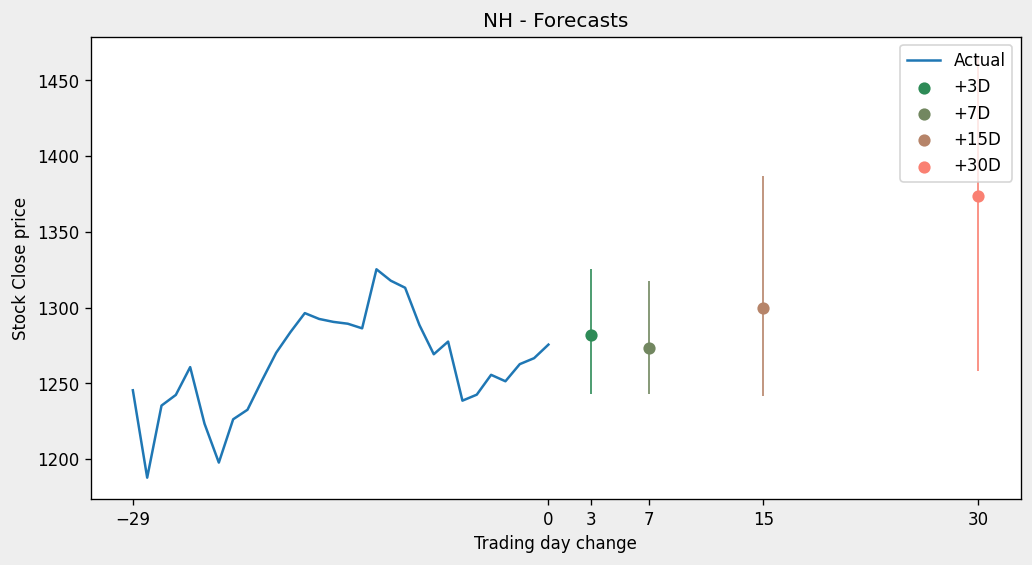

In [42]:
plt.figure(figsize = (10, 5), dpi = 120, facecolor = "#eee")

plt.plot(
    range(-29, 1), 
    stock_data.processed['Close'].iloc[-30:], 
    label = "Actual"
)

latest_preds = stock_data.processed.iloc[-1]
print(f"Date: {latest_preds['Date'].date()}")
print(f"Close: {latest_preds['Close']}")

color_palette = sns.color_palette("blend:seagreen,salmon", n_colors = len(target_cols))
xticks = [-29, 0]

for i, target_col in enumerate(target_cols):
    print(f"{target_col}: {latest_preds[f'Pred {target_col}']}", end = " ")
    print(f"({latest_preds[f'LB {target_col}']} to {latest_preds[f'UB {target_col}']})")
    
    target_day = int(re.search("\d+", target_col)[0])
    xticks.append(target_day)

    plt.scatter(
        target_day, 
        latest_preds[f'Pred {target_col}'],
        color = color_palette[i],
        s = 40,
        label = f"+{target_day}D"
    )
    plt.vlines(
        x = target_day,
        ymin = latest_preds[f'LB {target_col}'],
        ymax = latest_preds[f'UB {target_col}'],
        linewidth = 1,
        colors = color_palette[i]
    )

plt.xlabel("Trading day change")
plt.ylabel("Stock Close price")
plt.title(f"{STOCK_SYMBOL} - Forecasts")
plt.xticks(xticks)
plt.legend()
plt.show()